In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import random

import warnings
warnings.filterwarnings("ignore")

## Baseline

In [62]:
train = pd.read_csv('./data/train/train.csv')

In [63]:
submission = pd.read_csv('./data/sample_submission.csv')

In [64]:
train

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0
...,...,...,...,...,...,...,...,...,...
52555,1094,21,30,0,0,2.4,70.70,-4,0.0
52556,1094,22,0,0,0,2.4,66.79,-4,0.0
52557,1094,22,30,0,0,2.2,66.78,-4,0.0
52558,1094,23,0,0,0,2.1,67.72,-4,0.0


In [65]:
# data를 넣어주면 
def preprocess_data(data, is_train=True):
    
    temp = data.copy()
    temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']] # day, minute, 

    if is_train==True:          
    
        temp['Target1'] = temp['TARGET'].shift(-48).fillna(method='ffill')   # 뒤에서 48개의 값을 지우고 가장 마지막 값으로 채운다
        temp['Target2'] = temp['TARGET'].shift(-48*2).fillna(method='ffill') # 뒤에서 96개의 값을 지우고 가장 마지막 값으로 채운다
        temp = temp.dropna()  # 결측치 제거
        
        return temp.iloc[:-96] # 아 이건 예측값이 0이 되버리니까 제거해버리는구나 ㅇㅋㅇㅋ

    elif is_train==False:
        
        temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]
                              
        return temp.iloc[-48:, :]


df_train = preprocess_data(train)
df_train.iloc[:48]

,Hour,TARGET,DHI,DNI,WS,RH,T,Target1,Target2
0,0,0.000000,0,0,1.5,69.08,-12,0.000000,0.000000
1,0,0.000000,0,0,1.5,69.06,-12,0.000000,0.000000
2,1,0.000000,0,0,1.6,71.78,-12,0.000000,0.000000
3,1,0.000000,0,0,1.6,71.75,-12,0.000000,0.000000
4,2,0.000000,0,0,1.6,75.20,-12,0.000000,0.000000
5,2,0.000000,0,0,1.5,69.29,-11,0.000000,0.000000
6,3,0.000000,0,0,1.5,72.56,-11,0.000000,0.000000
7,3,0.000000,0,0,1.4,72.55,-11,0.000000,0.000000
8,4,0.000000,0,0,1.3,74.62,-11,0.000000,0.000000
9,4,0.000000,0,0,1.3,74.61,-11,0.000000,0.000000


# RH(상대 습도)

In [66]:
def RH_2(df_train):
    df_train['new_RH']=0
    # RH가 ~20 사이, 20~40 사이, 40~60, 60~80, ~100
    df_train.loc[df_train['RH']<30,'new_RH'] = 0
    df_train.loc[(30<=df_train['RH']) & (df_train['RH']<60),'new_RH'] = 1
    df_train.loc[60<=df_train['RH'],'new_RH'] = 2
    return df_train

# WS(풍속)

In [67]:
def WS_3(df_train):
    df_train['new_WS']=0
    df_train.loc[df_train['WS']<1.5,'new_RH'] = 0
    df_train.loc[(1.5<=df_train['WS']) & (df_train['WS']<4),'new_WS'] = 1
    df_train.loc[(4<=df_train['WS']) & (df_train['WS']<6),'new_WS'] = 2
    df_train.loc[6<=df_train['WS'],'new_WS'] = 3
    return df_train

# DNI, DHI를 계산해서 GHI 계산

In [68]:
def cal_ghi(df):
    df['GHI']=0
    lst = list(df.columns)
    idx_hour = lst.index('Hour')
    idx_dhi = lst.index('DHI')
    idx_dni = lst.index('DNI')
    idx_ghi = lst.index('GHI')
    for i in range(len(df)):
        hour = df.iloc[i,idx_hour]
        if 8 <= hour <= 16:
            degree = (hour-7) * np.pi/18
            GHI = df.iloc[i,idx_dni] + df.iloc[i,idx_dhi]*(np.cos(90-degree))  # DHI +DNI*cos(Θ)
            if GHI<0:
                GHI=0
            df.iloc[i,idx_ghi] = GHI
    return df

# temperature

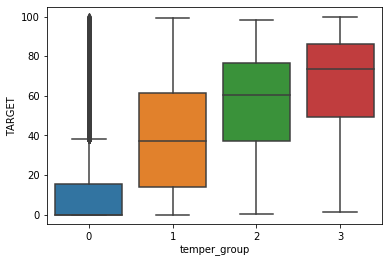

In [57]:
def temperature(temp_target):
    temp_target.loc[temp_target['T']<0,'temper_group'] = 0
    temp_target.loc[(0<= temp_target['T']) &(temp_target['T'] < 20),'temper_group'] = 1
    temp_target.loc[(20<= temp_target['T']) &(temp_target['T'] < 25),'temper_group'] = 2
    temp_target.loc[(25<= temp_target['T']) &(temp_target['T'] < 30),'temper_group'] = 3
    temp_target.loc[30 <= temp_target['T'],'temper_group'] = 4
    return temp_target
sns.boxplot(x='temper_group',y='TARGET',data=temperature(df_train))

In [72]:
def mmm(df):
    lst = []
    for i in range(0,len(df),48):
        temp = df[i:i+48]
        max_val = temp['T'].max()
        min_val = temp['T'].min()
        mean_val = temp['T'].mean()
        temp['max']=max_val
        temp['min']=min_val
        temp['mean']=mean_val
        lst.append(temp)
    return pd.concat(lst)

In [75]:
mm = mmm(df_train)
print(mm.columns)
mm

Index(['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T', 'Target1', 'Target2',
       'max', 'min', 'mean'],
      dtype='object')


,Hour,TARGET,DHI,DNI,WS,RH,T,Target1,Target2,max,min,mean
0,0,0.0,0,0,1.5,69.08,-12,0.0,0.0,-3,-12,-7.979167
1,0,0.0,0,0,1.5,69.06,-12,0.0,0.0,-3,-12,-7.979167
2,1,0.0,0,0,1.6,71.78,-12,0.0,0.0,-3,-12,-7.979167
3,1,0.0,0,0,1.6,71.75,-12,0.0,0.0,-3,-12,-7.979167
4,2,0.0,0,0,1.6,75.20,-12,0.0,0.0,-3,-12,-7.979167
...,...,...,...,...,...,...,...,...,...,...,...,...
52459,21,0.0,0,0,3.5,55.97,-1,0.0,0.0,9,-2,2.187500
52460,22,0.0,0,0,3.9,54.23,-2,0.0,0.0,9,-2,2.187500
52461,22,0.0,0,0,4.1,54.21,-2,0.0,0.0,9,-2,2.187500
52462,23,0.0,0,0,4.3,56.46,-2,0.0,0.0,9,-2,2.187500


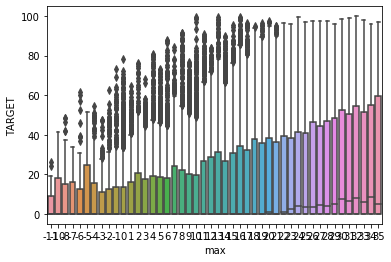

In [76]:
sns.boxplot(x='max',y='TARGET',data=mm)

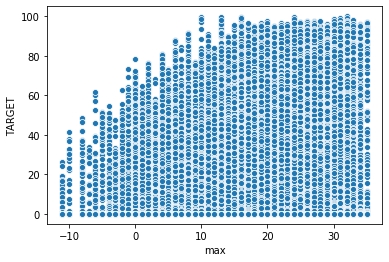

In [79]:
sns.scatterplot(x='max',y='TARGET',data=mm)

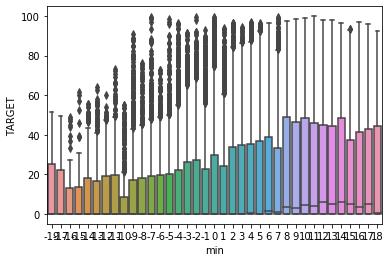

In [77]:
sns.boxplot(x='min',y='TARGET',data=mm)

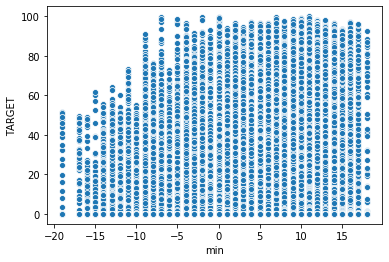

In [80]:
sns.scatterplot(x='min',y='TARGET',data=mm)

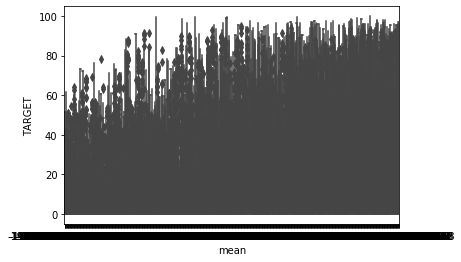

In [78]:
sns.boxplot(x='mean',y='TARGET',data=mm)

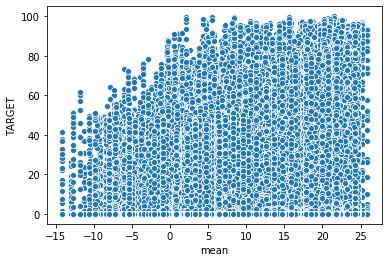

In [81]:
sns.scatterplot(x='mean',y='TARGET',data=mm)

In [24]:
def temp_gap(temp_target):
    temp_target['gap']=0
    for i in range(0,len(temp_target)//48,48):
        temp = temp_target[i:i+48]
        temp['gap']=temp['T'].max()-temp['T']
    return temp_target

In [25]:
df_traintemp_gap(df_train)

,Hour,TARGET,DHI,DNI,WS,RH,T,Target1,Target2,new_WS,new_RH,temper_group,gap
0,0,0.0,0,0,1.5,69.08,-12,0.0,0.0,0,0.0,0,9
1,0,0.0,0,0,1.5,69.06,-12,0.0,0.0,0,0.0,0,9
2,1,0.0,0,0,1.6,71.78,-12,0.0,0.0,0,0.0,0,9
3,1,0.0,0,0,1.6,71.75,-12,0.0,0.0,0,0.0,0,9
4,2,0.0,0,0,1.6,75.20,-12,0.0,0.0,0,0.0,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52459,21,0.0,0,0,3.5,55.97,-1,0.0,0.0,2,NaN,0,0
52460,22,0.0,0,0,3.9,54.23,-2,0.0,0.0,2,NaN,0,0
52461,22,0.0,0,0,4.1,54.21,-2,0.0,0.0,2,NaN,0,0
52462,23,0.0,0,0,4.3,56.46,-2,0.0,0.0,2,NaN,0,0


In [47]:
m = df_train['gap'].mean()
std = df_train['gap'].std()
df_train['no'] = (df_train['gap']-m)/std

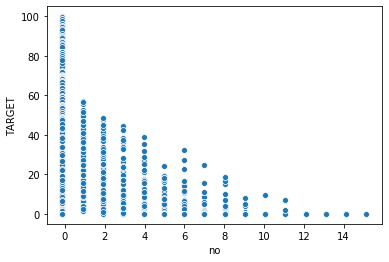

In [48]:
sns.scatterplot(x='no',y='TARGET',data=df_train)

In [39]:
def auto_bins(df,col_name,bin_num,new_col):
    min_val = df[col_name].min()
    max_val = df[col_name].max()
    boundary = (max_val-min_val+1)/bin_num
    
    for i in range(1,bin_num+1):
        df.loc[(min_val+boundary*(i-1)<=df[col_name]) &  (df[col_name] < min_val + boundary * i) ,new_col] = i-1
    return df

In [40]:
df_train = temp_gap(df_train)

In [41]:
df_train = auto_bins(df_train,'gap',8,'new_gap')

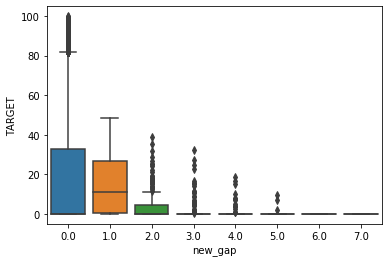

In [42]:
sns.boxplot(x='new_gap',y='TARGET',data=df_train)

# 당일 최고 기온으로 boxplot

In [50]:
df_train['max_temp']=0
for i in range(0,len(df_train),48):
    temp = df_train[i:i+48]
    max_val = temp['T'].max()
    temp['max_temp']=max_val

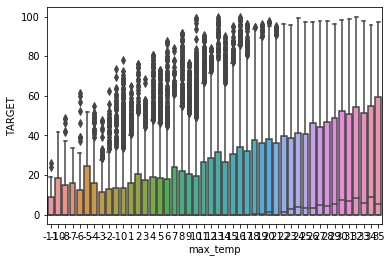

In [53]:
sns.boxplot(x='max_temp',y='TARGET',data=df_train)

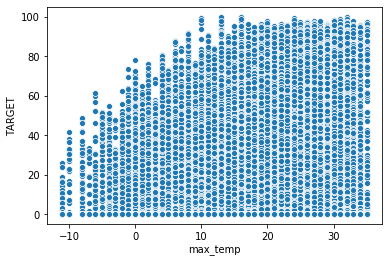

In [54]:
sns.scatterplot(x='max_temp',y='TARGET',data=df_train)

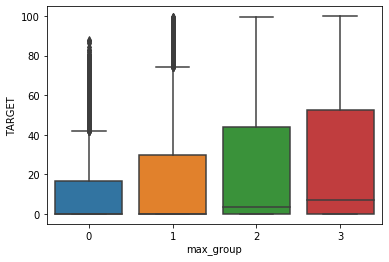

In [56]:
df_train['max_group'] = 0
df_train.loc[df_train['max_temp']<8,'max_group']=0
df_train.loc[(8<=df_train['max_temp'])&(df_train['max_temp']<22),'max_group'] = 1
df_train.loc[(22<=df_train['max_temp'])&(df_train['max_temp']<30),'max_group'] = 2
df_train.loc[30<=df_train['max_temp'],'max_group'] = 3
sns.boxplot(x='max_group',y='TARGET',data=df_train)

# 당일 최고 기온 * hour12가 가장 높고 멀어질수록 0에 가깝게.
|12 - hour|

In [55]:
df_train['r_hour']=0
df_train['r_hour']= (df_train['Hour'] - 12).abs()

In [ ]:
df_train['r_h']

In [ ]:


for i in range(0,len(df_train),48):
    temp = df_train[i:i+48]
    max_val = temp['T'].max()
    temp['max_temp']=max_val

# 당일 최고 습도로 boxplot

In [75]:
df_train = cal_ghi(df_train)
df_train = RH_2(df_train)
df_train = WS_2(df_train)
df_train = temperature(df_train)

# 최고 기온 * 최고 습도(백분율)

In [76]:
# T를 빼보고 싶은데
df_train = df_train[['Hour', 'new_WS', 'temper_group', 'GHI', 'new_RH', 'TARGET', 'Target1', 'Target2']]

In [77]:
df_test = []

for i in range(81):
    file_path = './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp = preprocess_data(temp, is_train=False)
    df_test.append(temp)

X_test = pd.concat(df_test)
X_test.shape

(3888, 7)

In [78]:
X_test

,Hour,TARGET,DHI,DNI,WS,RH,T
288,0,0.0,0,0,0.8,80.92,-2.8
289,0,0.0,0,0,0.9,81.53,-2.9
290,1,0.0,0,0,1.0,79.91,-3.0
291,1,0.0,0,0,0.9,79.91,-3.0
292,2,0.0,0,0,0.9,77.20,-3.0
...,...,...,...,...,...,...,...
331,21,0.0,0,0,0.8,63.35,13.7
332,22,0.0,0,0,0.7,64.82,13.1
333,22,0.0,0,0,0.7,66.10,12.8
334,23,0.0,0,0,0.6,67.64,12.4


In [79]:
X_test['GHI']=0
for i in range(len(X_test)):
    hour = X_test.iloc[i,0]
    if 8 <= hour <= 16:
        degree = (hour-7) * np.pi/18
        GHI = X_test.iloc[i,3] + X_test.iloc[i,2]*(np.cos(90-degree))  # DHI +DNI*cos(Θ)
        if GHI<0:
            GHI=0
        X_test.iloc[i,7] = GHI

In [80]:
X_test = temperature(X_test)

In [81]:
X_test = WS_2(X_test)
X_test = RH_1(X_test)
X_test = X_test[['Hour', 'new_WS', 'temper_group', 'GHI', 'new_RH', 'TARGET']]
X_test

,Hour,new_WS,temper_group,GHI,new_RH,TARGET
288,0,0,0,0.0,3,0.0
289,0,0,0,0.0,3,0.0
290,1,0,0,0.0,3,0.0
291,1,0,0,0.0,3,0.0
292,2,0,0,0.0,3,0.0
...,...,...,...,...,...,...
331,21,0,2,0.0,3,0.0
332,22,0,2,0.0,3,0.0
333,22,0,2,0.0,3,0.0
334,23,0,2,0.0,3,0.0


In [82]:
print(set(df_train.columns))
print(set(X_test.columns))
print(set(df_train.columns)-set(X_test.columns))

{'TARGET', 'temper_group', 'new_WS', 'Hour', 'Target1', 'GHI', 'Target2', 'new_RH'}
{'TARGET', 'temper_group', 'new_WS', 'Hour', 'GHI', 'new_RH'}
{'Target1', 'Target2'}


In [83]:
from sklearn.model_selection import train_test_split
X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(df_train.iloc[:, :-2], df_train.iloc[:, -2], test_size=0.3, random_state=0)
X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(df_train.iloc[:, :-2], df_train.iloc[:, -1], test_size=0.3, random_state=0)

In [84]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [85]:
from lightgbm import LGBMRegressor

# Get the model and the predictions in (a) - (b)
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', alpha=q,
                         n_estimators=10000, bagging_fraction=0.7, learning_rate=0.027, subsample=0.7)                   
                         
                         
    model.fit(X_train, Y_train, eval_metric = ['quantile'], 
          eval_set=[(X_valid, Y_valid)], early_stopping_rounds=300, verbose=500)

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

In [86]:
# Target 예측

def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in quantiles:
        print(q)
        pred , model = LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)

    LGBM_actual_pred.columns=quantiles
    
    return LGBM_models, LGBM_actual_pred

In [87]:
# Target1
models_1, results_1 = train_data(X_train_1, Y_train_1, X_valid_1, Y_valid_1, X_test)
results_1.sort_index()[:48]

0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[128]	valid_0's quantile: 1.39437
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.24021
Early stopping, best iteration is:
[397]	valid_0's quantile: 2.23987
0.3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.66799
Early stopping, best iteration is:
[526]	valid_0's quantile: 2.66768
0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [88]:
# Target2
models_2, results_2 = train_data(X_train_2, Y_train_2, X_valid_2, Y_valid_2, X_test)
results_2.sort_index()[:48]

0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 1.40395
Early stopping, best iteration is:
[319]	valid_0's quantile: 1.40142
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.25567
Early stopping, best iteration is:
[564]	valid_0's quantile: 2.25439
0.3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.69981
[1000]	valid_0's quantile: 2.70031
Early stopping, best iteration is:
[778]	valid_0's quantile: 2.6987
0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [89]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values
submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7772,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7773,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7774,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
submission.to_csv('./data/ws2,rh2,t_group.csv', index=False)